<font size="8"> <center> Quality Control Analysis Of Sequenced Data</center> </font>

Autor : Luiz Carlos Vieira  
Date: 06/06/2022

## Overview  

The data analysed containing sample quality control information for 300 sequencing batches.  
Each file contains data for one batch containing 96 samples. These sequencing samples were  
processed with the bellow workflow.

Column names are noted in parentheses.

1. DNA extraction ("sample_type" and sample "barcode" recorded)
2. DNA fragmentation
    - in-process QC metric: average fragment size ("frag_size")
    - in-process QC metric: DNA concentration ("pre_quant")
3. library preparation
    a. blunt-end
    b. A-tailing
    c. adapter ligation
4. PCR
    - in-process QC metric: DNA concentration ("post_quant")
5. target enrichment
6. sequencing
    - sequencing QC flag: sequencing coverage ("coverage")
    - sequencing QC flag: reliable CNV calling ("CNV_calling")
    - Sample quality is assessed during calling review using QC metrics and manual
	inspection of the data to make a final call ("passed_well")

### Questions to answer - Part 1: Sequence QC Analysis  

A.1 What percentage of samples have passed sequencing QC?  
*[Answer](#section_A1): 98.76 %*  
A.2 What percentage have failed due to low sequencing coverage?  
*[Answer](#section_A2): 1.24 %*  
A.3 What percentage of samples passed sequencing coverage but failed due to CNV calling?  
*[Answer](#section_A3): 5.00 %*  

B.1 Does "sample_type" relate to failing sequencing coverage QC?  
*[Answer](#section_B1): The sample type are related to failing in sequencing coverage QC*  

B.2 Does "sample_type" relate to passing coverage but failing CNV calling QC?  
*[Answer](#section_B2): The sample type has no relation to the status (pass or fail) of CNV_calling, if the sample has passed on coverage qc.*  

C.1 Which in-process QC metrics are indicative of failing sequencing due to low coverage?  
*[Answer](#section_C1): The QC metric that has the big impact on the status of failing in the sequencing due to low coverage is "post_quant".*  

C.2 Which metrics are indicative of passing coverage but failing CNV calling?  
Report your findings graphically with a figure legend.  
*[Answer](#section_C2): The metric related with passing on coverage but failing CNV calling is "post_quant"*  

D) Have the in-process QC metrics been stable over time (note: batches are processed in numerical order)?  
Report your findings graphically with a figure legend.  
*[Answer](#section_D): The time has no effect on QC metrics*  

### Part-2 An [alternative analysis](#section_part-2) of GC content bias
Here I descrive a alternative approach to avoid samples with high probability to fail in CNV_calling to undergo sequencing.


# Part 1 - Sequence QC Analysis

In [1]:
# libraries
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# setting some parameters
sns.set_style("darkgrid")
pd.set_option('display.max_columns', 50, 'display.min_rows', 20)
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Python Version
from platform import python_version
print('The python version used in this Jupyter Notebook is:', python_version())

The python version used in this Jupyter Notebook is: 3.8.8


### Data

In [4]:
# find all the .txt files in the seq_qc_data folder
files_in_dir = []
for file in os.listdir("seq_qc_data"):
    if file.endswith(".txt"):
        files_in_dir.append(os.path.join("seq_qc_data", file))
 

In [5]:
# adding batch_iD column
list_of_files = []
for i in files_in_dir:
    file = pd.read_csv(i, delimiter='\s+', encoding='utf-8')
    basename = i.split("\\")[-1].split(".")[-2]
    file["batch_ID"] = basename
    list_of_files.append(file)

data = pd.concat(list_of_files)
data


,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID
0,11003983829384,blood,617,44.2660,565.1010,passed,passed,passed,SEQ_00001
1,11006875693894,blood,605,46.2890,540.5860,passed,passed,passed,SEQ_00001
2,11004739959773,blood,540,40.2700,575.0350,passed,passed,passed,SEQ_00001
3,11004651860473,blood,618,42.9250,560.4100,passed,passed,passed,SEQ_00001
4,55000241940904,saliva,518,39.4550,573.3510,passed,passed,passed,SEQ_00001
5,55001584273148,saliva,554,32.0080,591.3090,passed,passed,passed,SEQ_00001
6,55007383648670,saliva,577,49.8990,614.1260,passed,passed,passed,SEQ_00001
7,11007500545247,blood,679,42.2350,585.3280,passed,passed,passed,SEQ_00001
8,11009699566756,blood,494,38.1080,564.1710,passed,passed,passed,SEQ_00001
9,11004177857806,blood,543,42.6950,571.2540,passed,passed,passed,SEQ_00001


<a id="section_A1"></a>
### A.1 What percentage of samples have passed sequencing QC? 

In [6]:
# A.1 What percentage of samples have passed sequencing QC?
data.query('passed_well == "passed"')

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID
0,11003983829384,blood,617,44.2660,565.1010,passed,passed,passed,SEQ_00001
1,11006875693894,blood,605,46.2890,540.5860,passed,passed,passed,SEQ_00001
2,11004739959773,blood,540,40.2700,575.0350,passed,passed,passed,SEQ_00001
3,11004651860473,blood,618,42.9250,560.4100,passed,passed,passed,SEQ_00001
4,55000241940904,saliva,518,39.4550,573.3510,passed,passed,passed,SEQ_00001
5,55001584273148,saliva,554,32.0080,591.3090,passed,passed,passed,SEQ_00001
6,55007383648670,saliva,577,49.8990,614.1260,passed,passed,passed,SEQ_00001
7,11007500545247,blood,679,42.2350,585.3280,passed,passed,passed,SEQ_00001
8,11009699566756,blood,494,38.1080,564.1710,passed,passed,passed,SEQ_00001
9,11004177857806,blood,543,42.6950,571.2540,passed,passed,passed,SEQ_00001


In [7]:
a1 = len(data.query('passed_well == "passed"')) / len(data.passed_well) * 100
print('Answer: {:.2f}% of samples have passed on sequencing QC'.format(a1))

Answer: 98.76% of samples have passed on sequencing QC


<a id="section_A2"></a>
### A.2 What percentage have failed due to low sequencing coverage? 

In [8]:
# A.2 What percentage have failed due to low sequencing coverage?
data.query('coverage == "failed"')

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID
7,55000685907796,saliva,457,1.3590,184.1100,failed,failed,failed,SEQ_00002
9,11005235707618,blood,577,52.3000,200.8350,failed,failed,failed,SEQ_00002
65,55003827817579,saliva,422,5.9820,110.5310,failed,failed,failed,SEQ_00003
95,11001525436326,blood,446,1.4360,231.9920,failed,failed,failed,SEQ_00003
25,55007923911800,saliva,511,0.0580,134.8290,failed,failed,failed,SEQ_00007
60,55007226452191,saliva,435,30.7610,136.0670,failed,failed,failed,SEQ_00007
57,55001227470542,saliva,502,23.3670,24.6950,failed,failed,failed,SEQ_00008
40,11004625948441,blood,385,37.9620,132.6150,failed,failed,failed,SEQ_00009
74,55009768075966,saliva,463,54.7770,181.7120,failed,failed,failed,SEQ_00009
84,55004101863608,saliva,478,53.9710,225.0550,failed,failed,failed,SEQ_00009


In [9]:
a2 = len(data.query('coverage == "failed"')) / len(data) * 100
print('Answer: {:.2f} % of samples have failed due to low sequencing coverage'.format(a2))

Answer: 1.24 % of samples have failed due to low sequencing coverage


<a id="section_A3"></a>
### A.3 What percentage of samples passed sequencing coverage but failed due to CNV calling?

In [10]:
# A.3 What percentage of samples passed sequencing coverage but failed due to CNV calling?
data.query('coverage == "passed" and CNV_calling == "failed"')

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID
11,11007754041816,blood,523,41.0120,394.5350,passed,failed,passed,SEQ_00001
52,55009752612761,saliva,613,52.5440,426.1780,passed,failed,passed,SEQ_00001
71,11007279249728,blood,622,40.1280,506.4070,passed,failed,passed,SEQ_00001
80,55005158496132,saliva,507,52.9140,460.9690,passed,failed,passed,SEQ_00001
34,55006856012338,saliva,560,33.2560,521.7560,passed,failed,passed,SEQ_00003
54,11003400082912,blood,500,42.1640,480.7410,passed,failed,passed,SEQ_00003
60,11001971231469,blood,532,49.2960,398.4610,passed,failed,passed,SEQ_00003
73,11004878164081,blood,515,39.9110,549.8100,passed,failed,passed,SEQ_00003
87,11001087622365,blood,528,42.0790,508.4560,passed,failed,passed,SEQ_00003
39,11000414475327,blood,523,58.2040,413.3170,passed,failed,passed,SEQ_00004


In [11]:
a3 = len(data.query('coverage == "passed" and CNV_calling == "failed"')) / len(data) * 100 
print('Answer: {:.2f}% of samples have passed sequencing coverage but failed due to CNV calling'.format(a3))


Answer: 5.00% of samples have passed sequencing coverage but failed due to CNV calling


<a id="section_B1"></a>
### B.1 Does "sample_type" relate to failing sequencing coverage QC? 

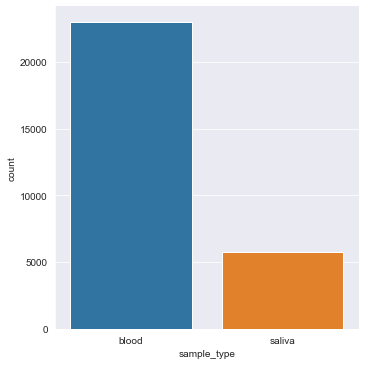

In [12]:
# Checking the data distribution between sample_type
sns.catplot(x="sample_type", data=data, kind="count")

The data are not even distribuited between samples, there are much more blood sample tested than saliva.  

To be able to make a fair assumption about their relation, we need to subset the data equaly.
If we use the raw data we'll end up making wrong assuntions, since the data has an uneven distribution between sample types.

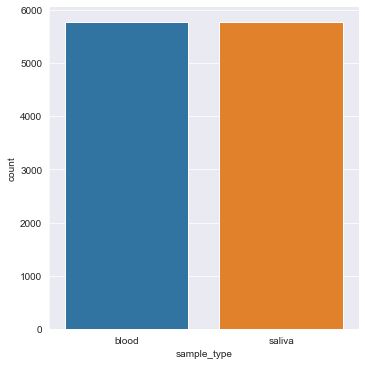

In [13]:
# subseting the data
subset_saliva = data.query('sample_type == "saliva"')
subset_blood = data.query('sample_type == "blood"').sample(n=len(subset_saliva))

sample_data = pd.concat([subset_blood, subset_saliva])

# checking distribuition
sns.catplot(x="sample_type", data=sample_data, kind="count")

Now they are equal

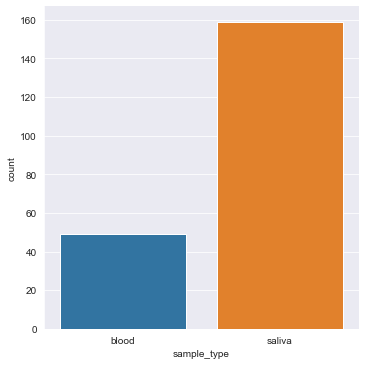

In [14]:
# closer look into the sample_type and coverage qc failed
cov_fail = sample_data.query('coverage == "failed"')
sns.catplot(x="sample_type", data=cov_fail, kind="count")

By looking at the data we could say that sample type has some influence in the status of the coverage qc.  
But we need to prove and test it.


### chi-square test of independence

Creating the hypotesis:  
ho: Status of the sample (passed and fail) and the type of sample are independent (not related)  
hA: Status of the sample (passed and fail) and the type of sample are not independent (so they are related)  

if p-value > 0.05, we fail to reject the null(ho) hipotesis.  
if p-value < 0.05, the alternative hypotesis (hA) is true, indicating that sample_type are related with the status of the samples.


sample_type   blood  saliva
coverage                   
failed       0.8495  2.7566
passed      99.1505 97.2434


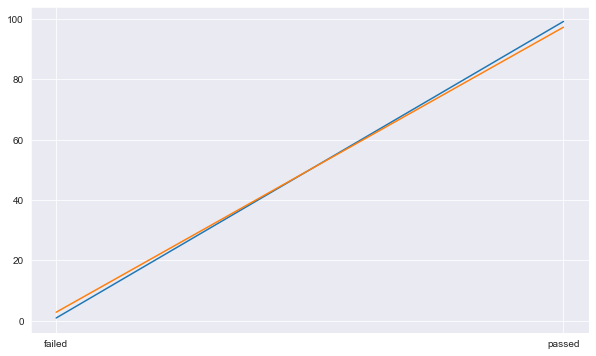

In [15]:
# Relative frequency of data that has passed into coverage qc
Xtab = pd.crosstab(index=sample_data.coverage, columns=sample_data.sample_type, normalize='columns') * 100
print(Xtab)

plt.figure(figsize=(10,6))
plt.plot(Xtab)

From the data above we can see that: 0.76% of the blood sample failed in coverage qc. On the other hand 2.75% of saliva samples have failed.  
It's a difference, but is it significant?  

Let's execute a chi-square test to compare the differences beetween this categorical variables.

In [16]:
# Creating a oberved table counts
Xtab = pd.crosstab(sample_data.coverage, sample_data.sample_type)
print(f'Observed table counts:\n{Xtab}')
print()

# Executing chi-square test
chi2Res = stats.chi2_contingency(Xtab, correction=True)

# Print tables and statistics
print('Expected contingency table (>5)') 
print(chi2Res[3])

print("\nStatistics:")
print(f'Degree of freedom: {chi2Res[2]}')
print(f'chi-square statistic: {chi2Res[0]}')
print(f'p-value: {chi2Res[1]}')

Observed table counts:
sample_type  blood  saliva
coverage                  
failed          49     159
passed        5719    5609

Expected contingency table (>5)
[[ 104.  104.]
 [5664. 5664.]]

Statistics:
Degree of freedom: 1
chi-square statistic: 58.16900939808778
p-value: 2.4053861855537267e-14


### Answer
From the results above we can conclued that:  
Sample type are related to failing in sequencing coverage QC.

<a id="section_B2"></a>
### B.2 Does "sample_type" relate to passing coverage but failing CNV calling QC?

In [17]:
counts = pd.DataFrame({"counts": sample_data.groupby(["sample_type", "coverage", "CNV_calling"]).size()}).reset_index()
counts.query('coverage == "passed"')

,sample_type,coverage,CNV_calling,counts
1,blood,passed,failed,266
2,blood,passed,passed,5453
4,saliva,passed,failed,294
5,saliva,passed,passed,5315


By looking at the data they look almost the same, with a small difference on the counts


<Figure size 864x576 with 0 Axes>

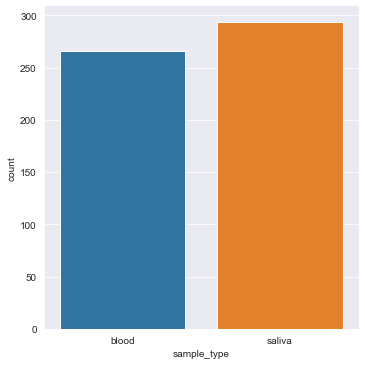

In [18]:
# Lets plot it
COVp_CNVf = sample_data.query('coverage == "passed" and CNV_calling == "failed"')

plt.figure(figsize=(12,8))
sns.catplot(x="sample_type", data=COVp_CNVf, kind="count")

sample_type   blood  saliva
CNV_calling                
failed       4.6512  5.2416
passed      95.3488 94.7584


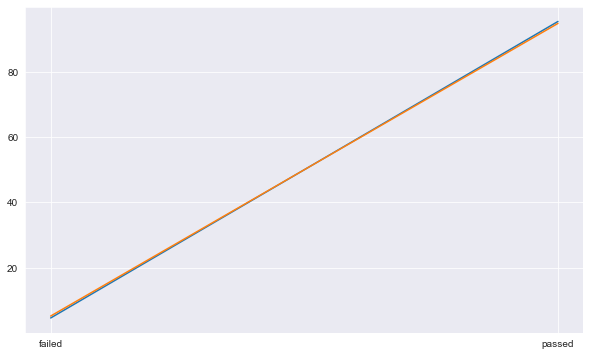

In [19]:
# The Relative frequency of data that has passed into coverage QC
COVp = sample_data.query('coverage == "passed"')
Xtab2 = pd.crosstab(index=COVp.CNV_calling, columns=COVp.sample_type, normalize='columns') * 100
print(Xtab2)

plt.figure(figsize=(10,6))
plt.plot(Xtab2)

The plot doesn't show us a clear difference between blood and saliva samples types that have failed in CNV calling.  
But once again we have to prove it.

In [20]:
# Creating a oberved table counts
Xtab2 = pd.crosstab(COVp.CNV_calling, COVp.sample_type)
print(f'Observed table counts:\n{Xtab2}')
print()

# Executing chi-square test
chi2Res = stats.chi2_contingency(Xtab2, correction=True)

# Print tables and statistics
print('Expected contingency table (>5)') 
print(chi2Res[3])

print("\nStatistics:")
print(f'Degree of freedom: {chi2Res[2]}')
print(f'chi-square statistic: {chi2Res[0]}')
print(f'p-value: {chi2Res[1]}')

Observed table counts:
sample_type  blood  saliva
CNV_calling               
failed         266     294
passed        5453    5315

Expected contingency table (>5)
[[ 282.71892655  277.28107345]
 [5436.28107345 5331.71892655]]

Statistics:
Degree of freedom: 1
chi-square statistic: 1.976857318613153
p-value: 0.15972187356303716


### Answer  
So from the data visualization and the chi-square test we can conclude that:  
The sample type has no relation to the status (pass or fail) of CNV_calling, if the sample has passed on coverage qc.

<a id="section_C1"></a>
### C.1 Which in-process QC metrics are indicative of failing sequencing due to low coverage?  
Report your findings graphically with a figure legend.

In [21]:
# Preparing the data
df_to_concat = data.drop(['barcode', "sample_type", "coverage", "CNV_calling", "passed_well"], axis=1)

# creating dummy values, this will change categorical data to numerical data
dummy2 = pd.get_dummies(data["coverage"])
dummy2.rename(columns={"failed":"COV_failed", "passed":"COV_passed"}, inplace=True)

dummy3 = pd.get_dummies(data["CNV_calling"])
dummy3.rename(columns={"failed":"CNV_failed", "passed":"CNV_passed"}, inplace=True)

dummy4 = pd.get_dummies(data["passed_well"])

# Concateneting the data frames
df = pd.concat([df_to_concat, dummy2, dummy3, dummy4], axis=1)

df.head()

,frag_size,pre_quant,post_quant,batch_ID,COV_failed,COV_passed,CNV_failed,CNV_passed,failed,passed
0,617,44.2660,565.1010,SEQ_00001,0,1,0,1,0,1
1,605,46.2890,540.5860,SEQ_00001,0,1,0,1,0,1
2,540,40.2700,575.0350,SEQ_00001,0,1,0,1,0,1
3,618,42.9250,560.4100,SEQ_00001,0,1,0,1,0,1
4,518,39.4550,573.3510,SEQ_00001,0,1,0,1,0,1


In [22]:
# Checking the correlation
df.corr()

,frag_size,pre_quant,post_quant,COV_failed,COV_passed,CNV_failed,CNV_passed,failed,passed
frag_size,1.0000,0.0140,-0.0163,0.0024,-0.0024,0.0080,-0.0080,0.0024,-0.0024
pre_quant,0.0140,1.0000,0.1530,-0.2627,0.2627,-0.1164,0.1164,-0.2627,0.2627
post_quant,-0.0163,0.1530,1.0000,-0.5710,0.5710,-0.4990,0.4990,-0.5710,0.5710
COV_failed,0.0024,-0.2627,-0.5710,1.0000,-1.0000,0.4343,-0.4343,1.0000,-1.0000
COV_passed,-0.0024,0.2627,0.5710,-1.0000,1.0000,-0.4343,0.4343,-1.0000,1.0000
CNV_failed,0.0080,-0.1164,-0.4990,0.4343,-0.4343,1.0000,-1.0000,0.4343,-0.4343
CNV_passed,-0.0080,0.1164,0.4990,-0.4343,0.4343,-1.0000,1.0000,-0.4343,0.4343
failed,0.0024,-0.2627,-0.5710,1.0000,-1.0000,0.4343,-0.4343,1.0000,-1.0000
passed,-0.0024,0.2627,0.5710,-1.0000,1.0000,-0.4343,0.4343,-1.0000,1.0000


<AxesSubplot:>

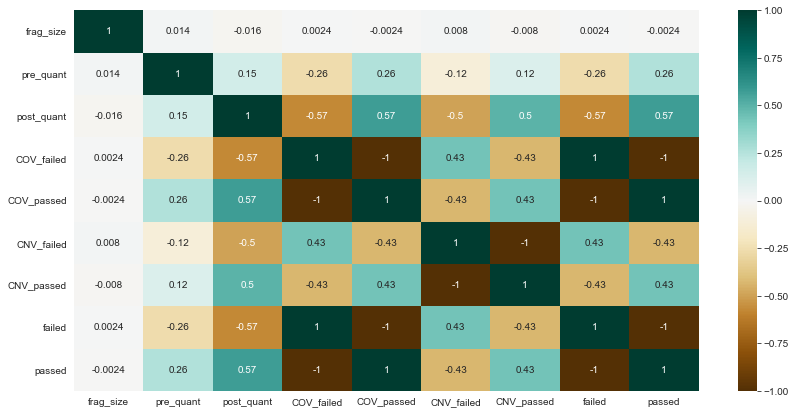

In [23]:
# Heatmap of correlation
plt.figure(figsize=(14,7))
sns.heatmap(df.corr(), annot=True, cmap='BrBG')

From the data correlation above we can see that "post-quant" has the strongest relation with the coverage failing, followed  by "pre_quant".  
This relation represents a negative correlation meaning, if the quantification of DNA increases in post quantification
the coverage failing tends to decrease.  

In [24]:
# Table representing the mean values of each in process QC
cols = ["frag_size","pre_quant", "post_quant"]
data.groupby(["coverage"])[cols].mean().reset_index()

,coverage,frag_size,pre_quant,post_quant
0,failed,507.4062,27.1806,144.8056
1,passed,506.0827,44.1220,541.5399


By looking at the table of mean values of quantification, it's more clear the differences between the failed and passed values on   
post_quant samples, regarding of caverage.  Which is higher when the sample pass on coverahe qc test.

In [25]:
# Preparing data for plotting and statistics
dfStats_c1 = (pd.melt(data, id_vars=["coverage"], value_vars=["frag_size", "post_quant", "pre_quant"]).reset_index(drop=True))
dfStats_c1.head()

,coverage,variable,value
0,passed,frag_size,617.0000
1,passed,frag_size,605.0000
2,passed,frag_size,540.0000
3,passed,frag_size,618.0000
4,passed,frag_size,518.0000


<AxesSubplot:xlabel='variable', ylabel='value'>

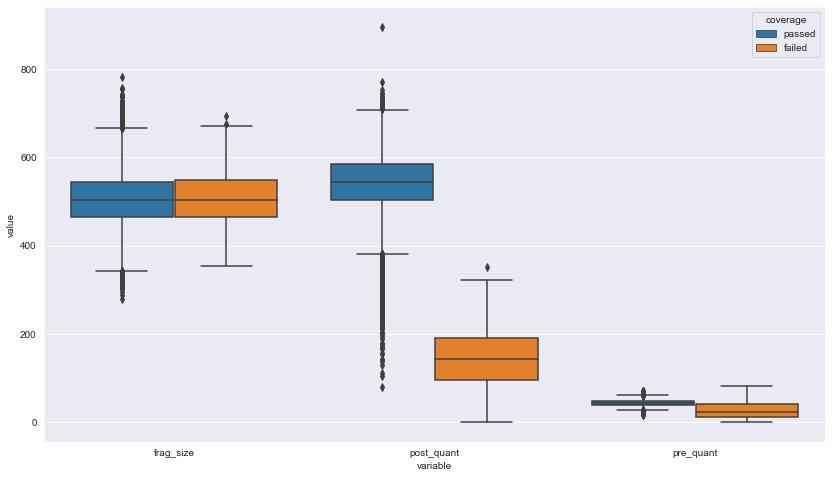

In [26]:
# Visualization of differences between qc metrics
plt.figure(figsize=(14,8))
sns.boxplot(x='variable', y='value', data=dfStats_c1, hue="coverage")

Now is clear that the differences between the status of each metric.
We see that the quantification of the samples that have passed in qc covarege are higher.

But we need to prove if this differences between failed and passed are significant for each variable. So let compute some statistics.

#### Checking assumptions for Statistical tests

In [27]:
# shapiro test to check normal distribution of frag_size
x0 = dfStats_c1.query('variable == "frag_size"')["value"].iloc[1:3000]
stat = stats.shapiro(x0)
print(f'frag_values: {stat}')

frag_values: ShapiroResult(statistic=0.9991496205329895, pvalue=0.1660253256559372)


((array([-3.50175825, -3.25802527, -3.12324104, ...,  3.12324104,
          3.25802527,  3.50175825]),
  array([287., 314., 315., ..., 679., 679., 714.])),
 (54.69005484609323, 498.3721240413471, 0.999527000421447))

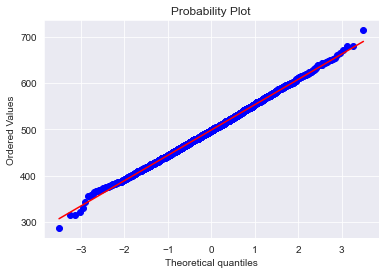

In [28]:
stats.probplot(x0, dist="norm", plot=pylab)

In [29]:
# shapiro test to check normal distribution pre_quant
x0 = dfStats_c1.query('variable == "pre_quant"')["value"].iloc[1:3000]
stat = stats.shapiro(x0)
print(f'pre_quant: {stat}')

pre_quant: ShapiroResult(statistic=0.9691693186759949, pvalue=6.874608230715161e-25)


((array([-3.50175825, -3.25802527, -3.12324104, ...,  3.12324104,
          3.25802527,  3.50175825]),
  array([5.8000e-02, 1.3590e+00, 1.4360e+00, ..., 6.5830e+01, 6.6275e+01,
         6.7596e+01])),
 (7.417771849614027, 43.959315771923976, 0.9842541614367893))

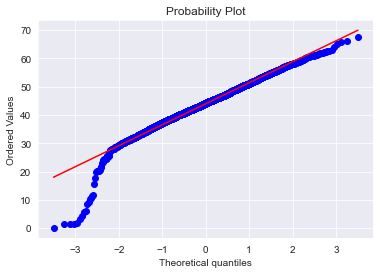

In [30]:
stats.probplot(x0, dist="norm", plot=pylab)

In [31]:
# shapiro test to check normal distribution post_quant
x0 = dfStats_c1.query('variable == "post_quant"')["value"].iloc[1:3000]
stat = stats.shapiro(x0)
print(f'post_quant: {stat}')

post_quant: ShapiroResult(statistic=0.818513035774231, pvalue=0.0)


((array([-3.50175825, -3.25802527, -3.12324104, ...,  3.12324104,
          3.25802527,  3.50175825]),
  array([ 24.695,  46.928,  64.508, ..., 667.086, 714.66 , 770.147])),
 (63.57907771526423, 539.1039186395465, 0.9042800315579219))

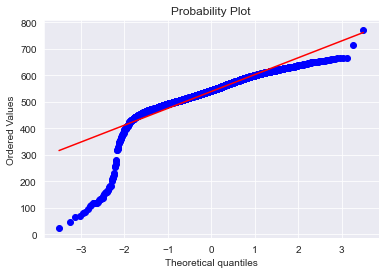

In [32]:
import pylab
stats.probplot(x0, dist="norm", plot=pylab)

### Tests

In [33]:
# stats for frag_size
x0 = dfStats_c1.query('coverage == "failed" and variable == "frag_size"')["value"]
x1 = dfStats_c1.query('coverage == "passed" and variable == "frag_size"')["value"]

# statistic test o acess the significance of those differences
stats.ttest_ind(x0, x1)

Ttest_indResult(statistic=0.40556112550944445, pvalue=0.6850681101226725)

In [34]:
# stats for pre_quant
x0 = dfStats_c1.query('coverage == "failed" and variable == "pre_quant"')["value"]
x1 = dfStats_c1.query('coverage == "passed" and variable == "pre_quant"')["value"]

# statistic test o acess the significance of those differences
stats.mannwhitneyu(x=x0, y=x1, alternative = 'two-sided')

MannwhitneyuResult(statistic=2094546.5, pvalue=2.289269142099542e-81)

In [35]:
# stats for post_quant
x0 = dfStats_c1.query('coverage == "failed" and variable == "post_quant"')["value"]
x1 = dfStats_c1.query('coverage == "passed" and variable == "post_quant"')["value"]

# statistic test o acess the significance of those differences
stats.mannwhitneyu(x=x0, y=x1, alternative = 'two-sided')

MannwhitneyuResult(statistic=5764.0, pvalue=1.726646246455034e-231)

Now we know for sure that the differences between fail and pass on pre_quant and post_quant are significantly different.

#### Answer C.1
Based on the statistcs and the data visualizaton we can conclude that:  
The QC metric that has the big impact on the status of failing in the sequencing due to low coverage is "post_quant".

<a id="section_C2"></a>
### C.2 Which metrics are indicative of passing coverage but failing CNV calling?
Report your findings graphically with a figure legend.

In [36]:
# grouping the data by covarege and CNV_calling by mean values of the metrics.
cols = ["frag_size","pre_quant", "post_quant"]
c2 = data.groupby(["coverage", "CNV_calling"])[cols].mean().reset_index()
c2

,coverage,CNV_calling,frag_size,pre_quant,post_quant
0,failed,failed,507.4062,27.1806,144.8056
1,passed,failed,508.1403,44.0413,448.1710
2,passed,passed,505.9730,44.1263,546.5191


As we can see on the table above, the main responsable for the failing in the CNV_calling qc even after passed of coverage still  
been the metric post_quantification.  

On the table we can observe a small decrease in the post_quant with no effect on the status of coverage,
but change the status of CNV_calling.  

This is more clear on the figure bellow.

Text(0.5, 0, '')

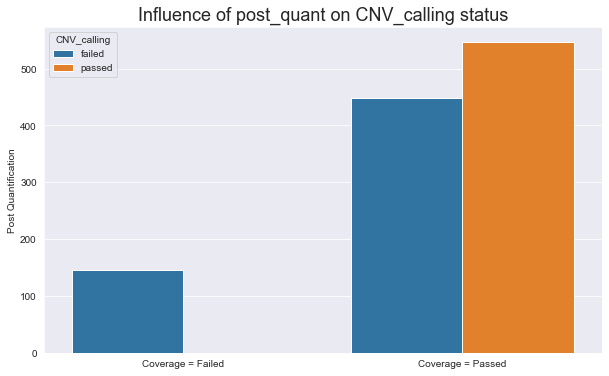

In [37]:
# plot represent the table c2
plt.figure(figsize=(10,6))
sns.barplot(data=c2, hue="CNV_calling", y="post_quant", x="coverage")
plt.title("Influence of post_quant on CNV_calling status", fontsize=18)
plt.xticks([0,1], ["Coverage = Failed", "Coverage = Passed"])
plt.ylabel("Post Quantification")
plt.xlabel("")

#### Legend
The eixo y represent post quantification, and the eixo x represents the coverage status failed (left) and passed (right). The colours represents the status of samples regared with CNV_calling. As observed just the sample with the highest concentration of DNA was able to pass in both tests.



Note: The correlation corroborates with the data on the table and the figure "Influence of post_quant on CNV_calling status".  
Since, we observed a negative correlation of post_quant with "coverage failed" and "CNV_calling failed" meaning that: if the quantification decrease the "coverage failed" and "CNV calling failed" will increase.  

#### Answer C.2
As supported by correlation and the visualization data, the metric related with passing on coverage but failing CNV calling is "post_quant".

<a id="section_D"></a>
### D. Have the in-process QC metrics been stable over time (note: batches are processed in numerical order)?  
Report your findings graphically with a figure legend.

First lets have a look at the percentage of counts that passed and failed over time.

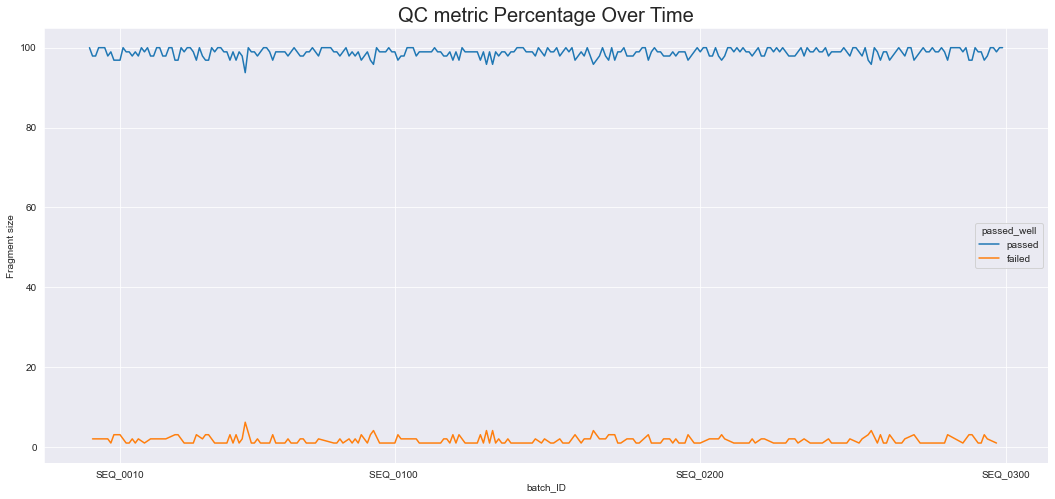

In [38]:
QC_counts = pd.DataFrame({"Percentage(%)": data.groupby(["batch_ID", "passed_well"]).size()*100/96}).reset_index() 

plt.figure(figsize=(18,8))
sns.lineplot(x="batch_ID", y="Percentage(%)", hue="passed_well", data=QC_counts)
plt.title("QC metric Percentage Over Time", fontsize=20)
plt.ylabel("Fragment size")
plt.xticks([10,100,200,300],["SEQ_0010", "SEQ_0100 ", "SEQ_0200", "SEQ_0300"], rotation=0)
plt.show()

Fom the plot above, the overall percentage of QC quality don't looks to change much over time.  

Showing batches that have passed with a percentage of quality over 90%, and the ones that have failed under 10%.

In [39]:
# get some statistics from the data
QC_counts.query('passed_well == "passed"').describe()

,Percentage(%)
count,300.0000
mean,98.7604
std,1.1045
min,93.7500
25%,97.9167
50%,98.9583
75%,100.0000
max,100.0000


In [40]:
# get some statistics from the data
QC_counts.query('passed_well == "failed"').describe()

,Percentage(%)
count,212.0000
mean,1.7541
std,0.9066
min,1.0417
25%,1.0417
50%,1.0417
75%,2.0833
max,6.2500


In [41]:
# Find the batch with the highest percentage of fail
QC_counts[QC_counts['Percentage(%)'] == 6.25]

,batch_ID,passed_well,Percentage(%)
84,SEQ_00052,failed,6.2500


From the image above and the statistics, we can see the the percentage of batches doesn't change much over time, having a small variantion 
of 1.1%.  

The mean percentage for batches with QC status equal passed is of 98% and 75% of batches have 100% aproval in the QC metrics.

For batches that failed in qc metrics the mean value of fail is 1.75%.  

The batch with the highest percentage of fail is the SEQ_00052 with 6.25%.

### QC metrics overtime

Let's have a look at each qc metric and see if the means of the metrics change over time.

In [42]:
 # Grouping the data by batch_ID sample type and QC
data["QC"] =  data["passed_well"]

metrics = (pd.melt(data, id_vars=["batch_ID", "sample_type", "QC"],
                      value_vars=["frag_size", "post_quant", "pre_quant"]).reset_index(drop=True))

metrics.head()

,batch_ID,sample_type,QC,variable,value
0,SEQ_00001,blood,passed,frag_size,617.0000
1,SEQ_00001,blood,passed,frag_size,605.0000
2,SEQ_00001,blood,passed,frag_size,540.0000
3,SEQ_00001,blood,passed,frag_size,618.0000
4,SEQ_00001,saliva,passed,frag_size,518.0000


>>> ### QC metric Frag_size

In [43]:
# filtering the metrics
frag_size = metrics.query("variable == 'frag_size'")

In [44]:
# get some statistics from the data
frag_size.query('QC == "passed"').describe()

,value
count,"28,443.0000"
mean,506.0827
std,61.2492
min,278.0000
25%,464.0000
50%,504.0000
75%,545.0000
max,783.0000


In [45]:
# get some statistics from the data
frag_size.query('QC == "failed"').describe()

,value
count,357.0000
mean,507.4062
std,63.1806
min,354.0000
25%,466.0000
50%,504.0000
75%,550.0000
max,695.0000


From the statistics we can see that fragment size is almost the same for both QC status (passed and failed).
Which was expected due this metric doesn't have much efect on QC status.

With a variation around 60s from a mean of 507, we can assume that this qc metric is consistent over time.


## Trend (Linear) Regression to verify tendency on the data

We need to prove that time has no effect on the quality of the batches. To verify this We can apply a linear regretion methods to verify this.  

The null hypothesis of the linear regression is that the coefficient is equal to zero (meaning no effect).
So with a p-value > 0.05, we can reject the null hypotesis, indicating that the the time has no effect on the quality of the samples.  

When you have a low p-value (typically < 0.05), the independent variable (time) is statistically significant on batches quality. 

[rvalue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) is the Pearson correlation coefficient. The square of rvalue is equal to the coefficient of determination(R-square).  
Which means the proportion of the variation in the dependent variable that is predictable or explained from the independent variable(s).  

So, small rvalues are the ones we expect, since values close to zero, doesn't explain or show any relatetion with the variation on the data. 


#### Trend Line

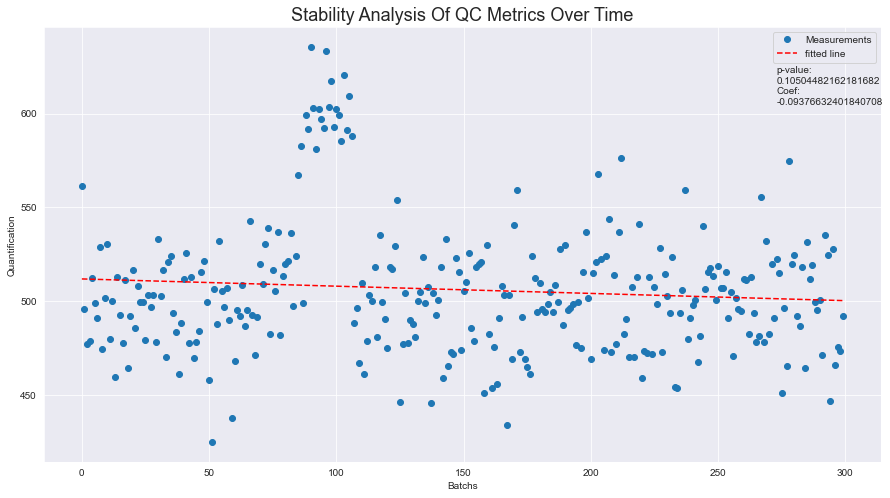

In [46]:
y = frag_size.groupby("batch_ID")["value"].mean().reset_index() 
x = y.index

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y.value)

plt.figure(figsize=(15, 8))
plt.plot(x, y.value, 'o', label='Measurements')
plt.plot(x, intercept + slope*x, 'r--', label='fitted line')
plt.text(273,605, f'p-value:\n{p_value}\nCoef:\n{r_value}')
plt.legend()
plt.title("Stability Analysis Of QC Metrics Over Time", fontsize=18)
plt.ylabel("Quantification")
plt.xlabel("Batchs")
plt.show()

From the plot we can notice a inconsistence in the frag_size, between batchs seq_0089 and seq_0107.  
But this don't seen to affect the overall quality over time.

In [47]:
# We could have a closer look at the batches ids with the hightest fragment size
ids = frag_size[frag_size.value.between(688,695)].batch_ID
f = data.batch_ID.isin(ids)
data[f]

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID,QC
0,11003002595774,blood,489,46.9260,610.8330,passed,passed,passed,SEQ_00087,passed
1,55001184665251,saliva,622,50.8800,634.6260,passed,passed,passed,SEQ_00087,passed
2,11007736584100,blood,587,37.9520,667.9010,passed,passed,passed,SEQ_00087,passed
3,11000990940424,blood,534,32.7720,660.7890,passed,passed,passed,SEQ_00087,passed
4,11006231303728,blood,613,41.5180,679.7800,passed,passed,passed,SEQ_00087,passed
5,11007559159863,blood,609,44.6870,642.8930,passed,passed,passed,SEQ_00087,passed
6,11006965630684,blood,568,35.8210,648.6560,passed,passed,passed,SEQ_00087,passed
7,55009271068630,saliva,607,48.0870,687.2730,passed,passed,passed,SEQ_00087,passed
8,55002393732908,saliva,616,39.3800,656.3470,passed,passed,passed,SEQ_00087,passed
9,11002779088954,blood,537,32.0970,608.8720,passed,passed,passed,SEQ_00087,passed


#### Conclusion for qc fragment size:
Based on a p-valeu of 0.10 and a r-value -0.009, we can conclude that time has no effect on the quality of the fragment size.


>>> ### QC metric pre_quant

In [48]:
# filtering the data
pre_quant = metrics.query("variable == 'pre_quant'")

In [49]:
# get some statistics from the data
pre_quant.query('QC == "passed"').describe()

,value
count,"28,443.0000"
mean,44.1220
std,6.6066
min,15.3660
25%,39.6160
50%,44.0440
75%,48.5260
max,71.4630


In [50]:
# get some statistics from the data
pre_quant.query('QC == "failed"').describe()

,value
count,357.0000
mean,27.1806
std,18.6432
min,0.0150
25%,12.1930
50%,23.7120
75%,40.8120
max,80.7790


From the statistics we now can notice some differences across pre quantification metrics.  
Obs: On samples that have failed the std is 18 from a mean of 27, which makes the data looks inconsistent.  

#### Trend Line

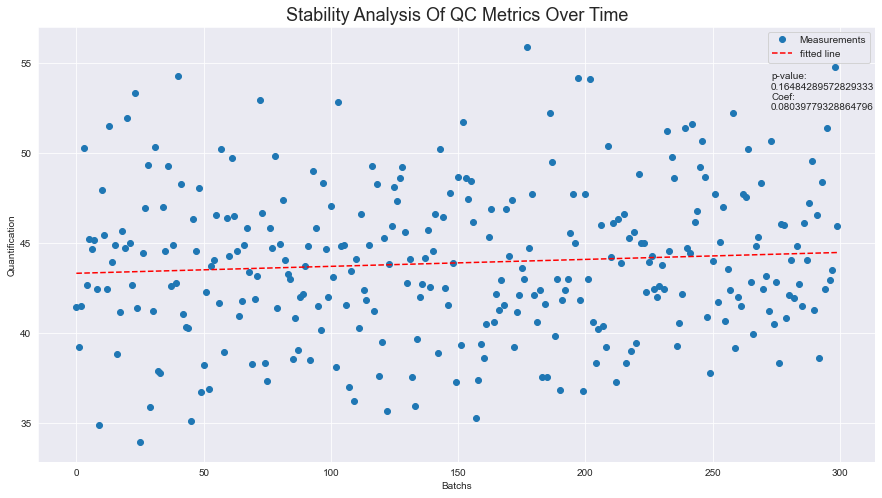

In [51]:
y = pre_quant.groupby("batch_ID")["value"].mean().reset_index() 
x = y.index

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y.value)

plt.figure(figsize=(15, 8))
plt.plot(x, y.value, 'o', label='Measurements')
plt.plot(x, intercept + slope*x, 'r--', label='fitted line')
plt.text(273,52.4, f'p-value:\n{p_value}\nCoef:\n{r_value}')
plt.title("Stability Analysis Of QC Metrics Over Time", fontsize=18)
plt.ylabel("Quantification")
plt.xlabel("Batchs")
plt.legend()
plt.show()

#### Conclusion for qc pre quantification:
Based on a p-valeu of 0.16 and a r-value -0.080, we can conclude that time has no effect on the quality of the pre quantification.

>>> ### QC metric post_quant

In [52]:
# Filtering the data
post_quant = metrics.query("variable == 'post_quant'").reset_index()

In [53]:
# get some statistics from the data
post_quant.query('QC == "passed"').describe()

,index,value
count,"28,443.0000","28,443.0000"
mean,"43,206.5709",541.5399
std,"8,316.4195",63.0361
min,"28,800.0000",79.1330
25%,"36,004.5000",503.7175
50%,"43,209.0000",544.7270
75%,"50,410.5000",585.5605
max,"57,599.0000",896.5750


In [54]:
# get some statistics from the data
post_quant.query('QC == "failed"').describe()

,index,value
count,357.0000,357.0000
mean,"42,636.1485",144.8056
std,"8,109.4979",69.3843
min,"28,903.0000",1.0270
25%,"35,573.0000",96.2110
50%,"42,073.0000",143.2240
75%,"49,057.0000",190.6930
max,"57,361.0000",351.4640


By looking at the data, even though the std seen to be equal we need to consider the mean they are deviating from.  
In the passed samples the std is -+63 for a mean of 541, and on the failed samples the std is -+69 for a mean of 144.  
Once again, we can see an inconsistency of the metrics that failed in qc metrics.

#### Trend Line

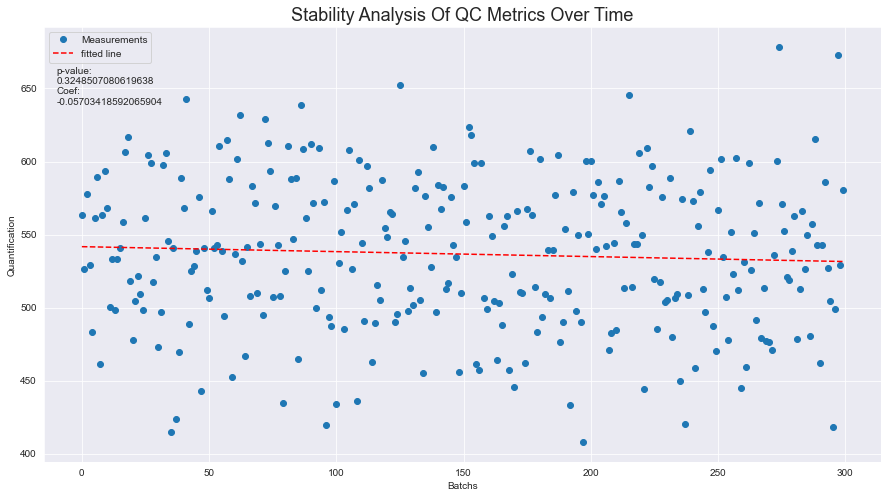

In [55]:
y = post_quant.groupby("batch_ID")["value"].mean().reset_index() 
x = y.index

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y.value)

plt.figure(figsize=(15, 8))
plt.plot(x, y.value, 'o', label='Measurements')
plt.plot(x, intercept + slope*x, 'r--', label='fitted line')
plt.text(-10,639, f'p-value:\n{p_value}\nCoef:\n{r_value}')
plt.title("Stability Analysis Of QC Metrics Over Time", fontsize=18)
plt.ylabel("Quantification")
plt.xlabel("Batchs")
plt.legend()
plt.show()

#### Conclusion for qc post quantification:
Based on a p-valeu of 0.32 and a r-value -0.057, we can conclude that time has no effect on the quality of the post quantification.

<a id="section_part-2"></a>
# Part-2 An alternative analysis of GC content bias

A naive CNV calling algorithm relies on unbiased sequencing to identify deletions and duplications from sequence coverage alone.  
A common bias in sequencing workflows is related to the GC content of the targeted regions, such that targeted regions at the  
extremities are over- or under-represented. To reduce turn-around-time and cost, samples that will ultimately be deemed unreliable  
for CNV calling should be identified prior to the sequencing step.

The uses of PCR during the amplification is a major source of errors in sequencing data and can skew read coverage. GC bias is on of the reasons of the sequences technologies given a low read coverage or fragment count in GC-rich regions of the genome [Thermo Ficher](https://bitesizebio.com/43478/estimating-and-eliminating-gc-bias-in-wgs-moving-beyond-pcr/).

High concentration of GC inhibit the DNA amplification ([Namadev Baskaran, et al, 1996](https://genome.cshlp.org/content/6/7/633.full.pdf+html)), so we can expect that the samples with a high GC concent shown a low post quantification.

To test that, we can measure the ratio between pre_quant/post_quant and find out which is the threshold for samples to be able to pass in CNV_calling.


In [56]:
# Creating a new column call ratio quantification
data["ratio_quant"] = data.post_quant / data.pre_quant

In [57]:
# Finding the mininum ratio to pass in CNV_calling
min_ratio = min(data.query('CNV_calling == "passed"').ratio_quant)
print(f"The minimum ratio value to pass in CNV calling is: {min_ratio}")

The minimum ratio value to pass in CNV calling is: 6.135789059425424


In [58]:
# Filtering data by ratio less than the minimum to pass in CNV_calling
data[data['ratio_quant'] <= min_ratio]

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID,QC,ratio_quant
9,11005235707618,blood,577,52.3000,200.8350,failed,failed,failed,SEQ_00002,failed,3.8401
43,55002067935691,saliva,569,51.3830,214.6390,passed,failed,passed,SEQ_00005,passed,4.1772
82,11000310508807,blood,617,37.3400,156.1530,passed,failed,passed,SEQ_00005,passed,4.1819
60,55007226452191,saliva,435,30.7610,136.0670,failed,failed,failed,SEQ_00007,failed,4.4234
57,55001227470542,saliva,502,23.3670,24.6950,failed,failed,failed,SEQ_00008,failed,1.0568
40,11004625948441,blood,385,37.9620,132.6150,failed,failed,failed,SEQ_00009,failed,3.4934
74,55009768075966,saliva,463,54.7770,181.7120,failed,failed,failed,SEQ_00009,failed,3.3173
84,55004101863608,saliva,478,53.9710,225.0550,failed,failed,failed,SEQ_00009,failed,4.1699
53,11008058206712,blood,496,33.4340,180.0870,failed,failed,failed,SEQ_00011,failed,5.3863
82,11008819425830,blood,488,41.6950,166.9470,failed,failed,failed,SEQ_00011,failed,4.0040


From the data above we can see that 322 samples due a lower quant_ratio could be ignored from sequencing step, reducing turn-around-time and cost.

################################################################################################################